In [5]:
import numpy as np  
from pathlib import Path
import json
import time 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.stats import spearmanr

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

import helper           
import clustering

c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',] * 10
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',] * 10
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',] * 10 
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['o', 'v', '*', '+', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
linestyles = ["-", "--", "-."]


In [6]:
# load and unpack parameters
# make sure to change out_path and out_param_path simultaneously
seed = "838"
task = "everything"
hidden = "100"
batch = "128"
# this file might be large, for the sake of completeness
out_path_name = "multiple_tasks/" + f"param_{task}_seed{seed}_inputtrain+Wtrain+yesoversample+hidden{hidden}+batch{batch}_result.npz"
out_path = Path(out_path_name)

size_bytes = out_path.stat().st_size  
size_gb = size_bytes / 1024**3 
print(f"{out_path} = {size_gb:.3f} GiB")

with np.load(out_path_name, allow_pickle=True) as data:
    rules_epochs = data["rules_epochs"]
    hyp_dict = data["hyp_dict"]
    all_rules = data["all_rules"]
    test_task = data["test_task"]
    # Ms = data["Ms"]
    Ms_orig = data["Ms_orig"]
    hs = data["hs"]
    bs = data["bs"]
    xs = data["xs"]

print(f"Ms_orig: {Ms_orig.shape}")
print(f"hs: {hs.shape}")
print(f"xs: {xs.shape}")

out_param_path = "multiple_tasks/" + f"param_{task}_seed{seed}_inputtrain+Wtrain+yesoversample+hidden{hidden}+batch{batch}_param.json"
out_param_path = Path(out_param_path)

with out_param_path.open() as f: 
    raw_cfg_param = json.load(f)

task_params, train_params, net_params = raw_cfg_param["task_params"], raw_cfg_param["train_params"], raw_cfg_param["net_params"]

FileNotFoundError: [Errno 2] No such file or directory: 'multiple_tasks/param_everything_seed838_inputtrain+Wtrain+yesoversample+hidden100+batch128_result.npz'

clustering_name: input


/home/zihan.zhang/.conda/envs/mpn/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/zihan.zhang/.conda/envs/mpn/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


clustering_name: hidden
clustering_name: modulation_all
cell_vars_rules_sorted_norm: (49, 10000)
(99, 4)
Pre: 0.039073901407607
Post: -0.02023233454489619


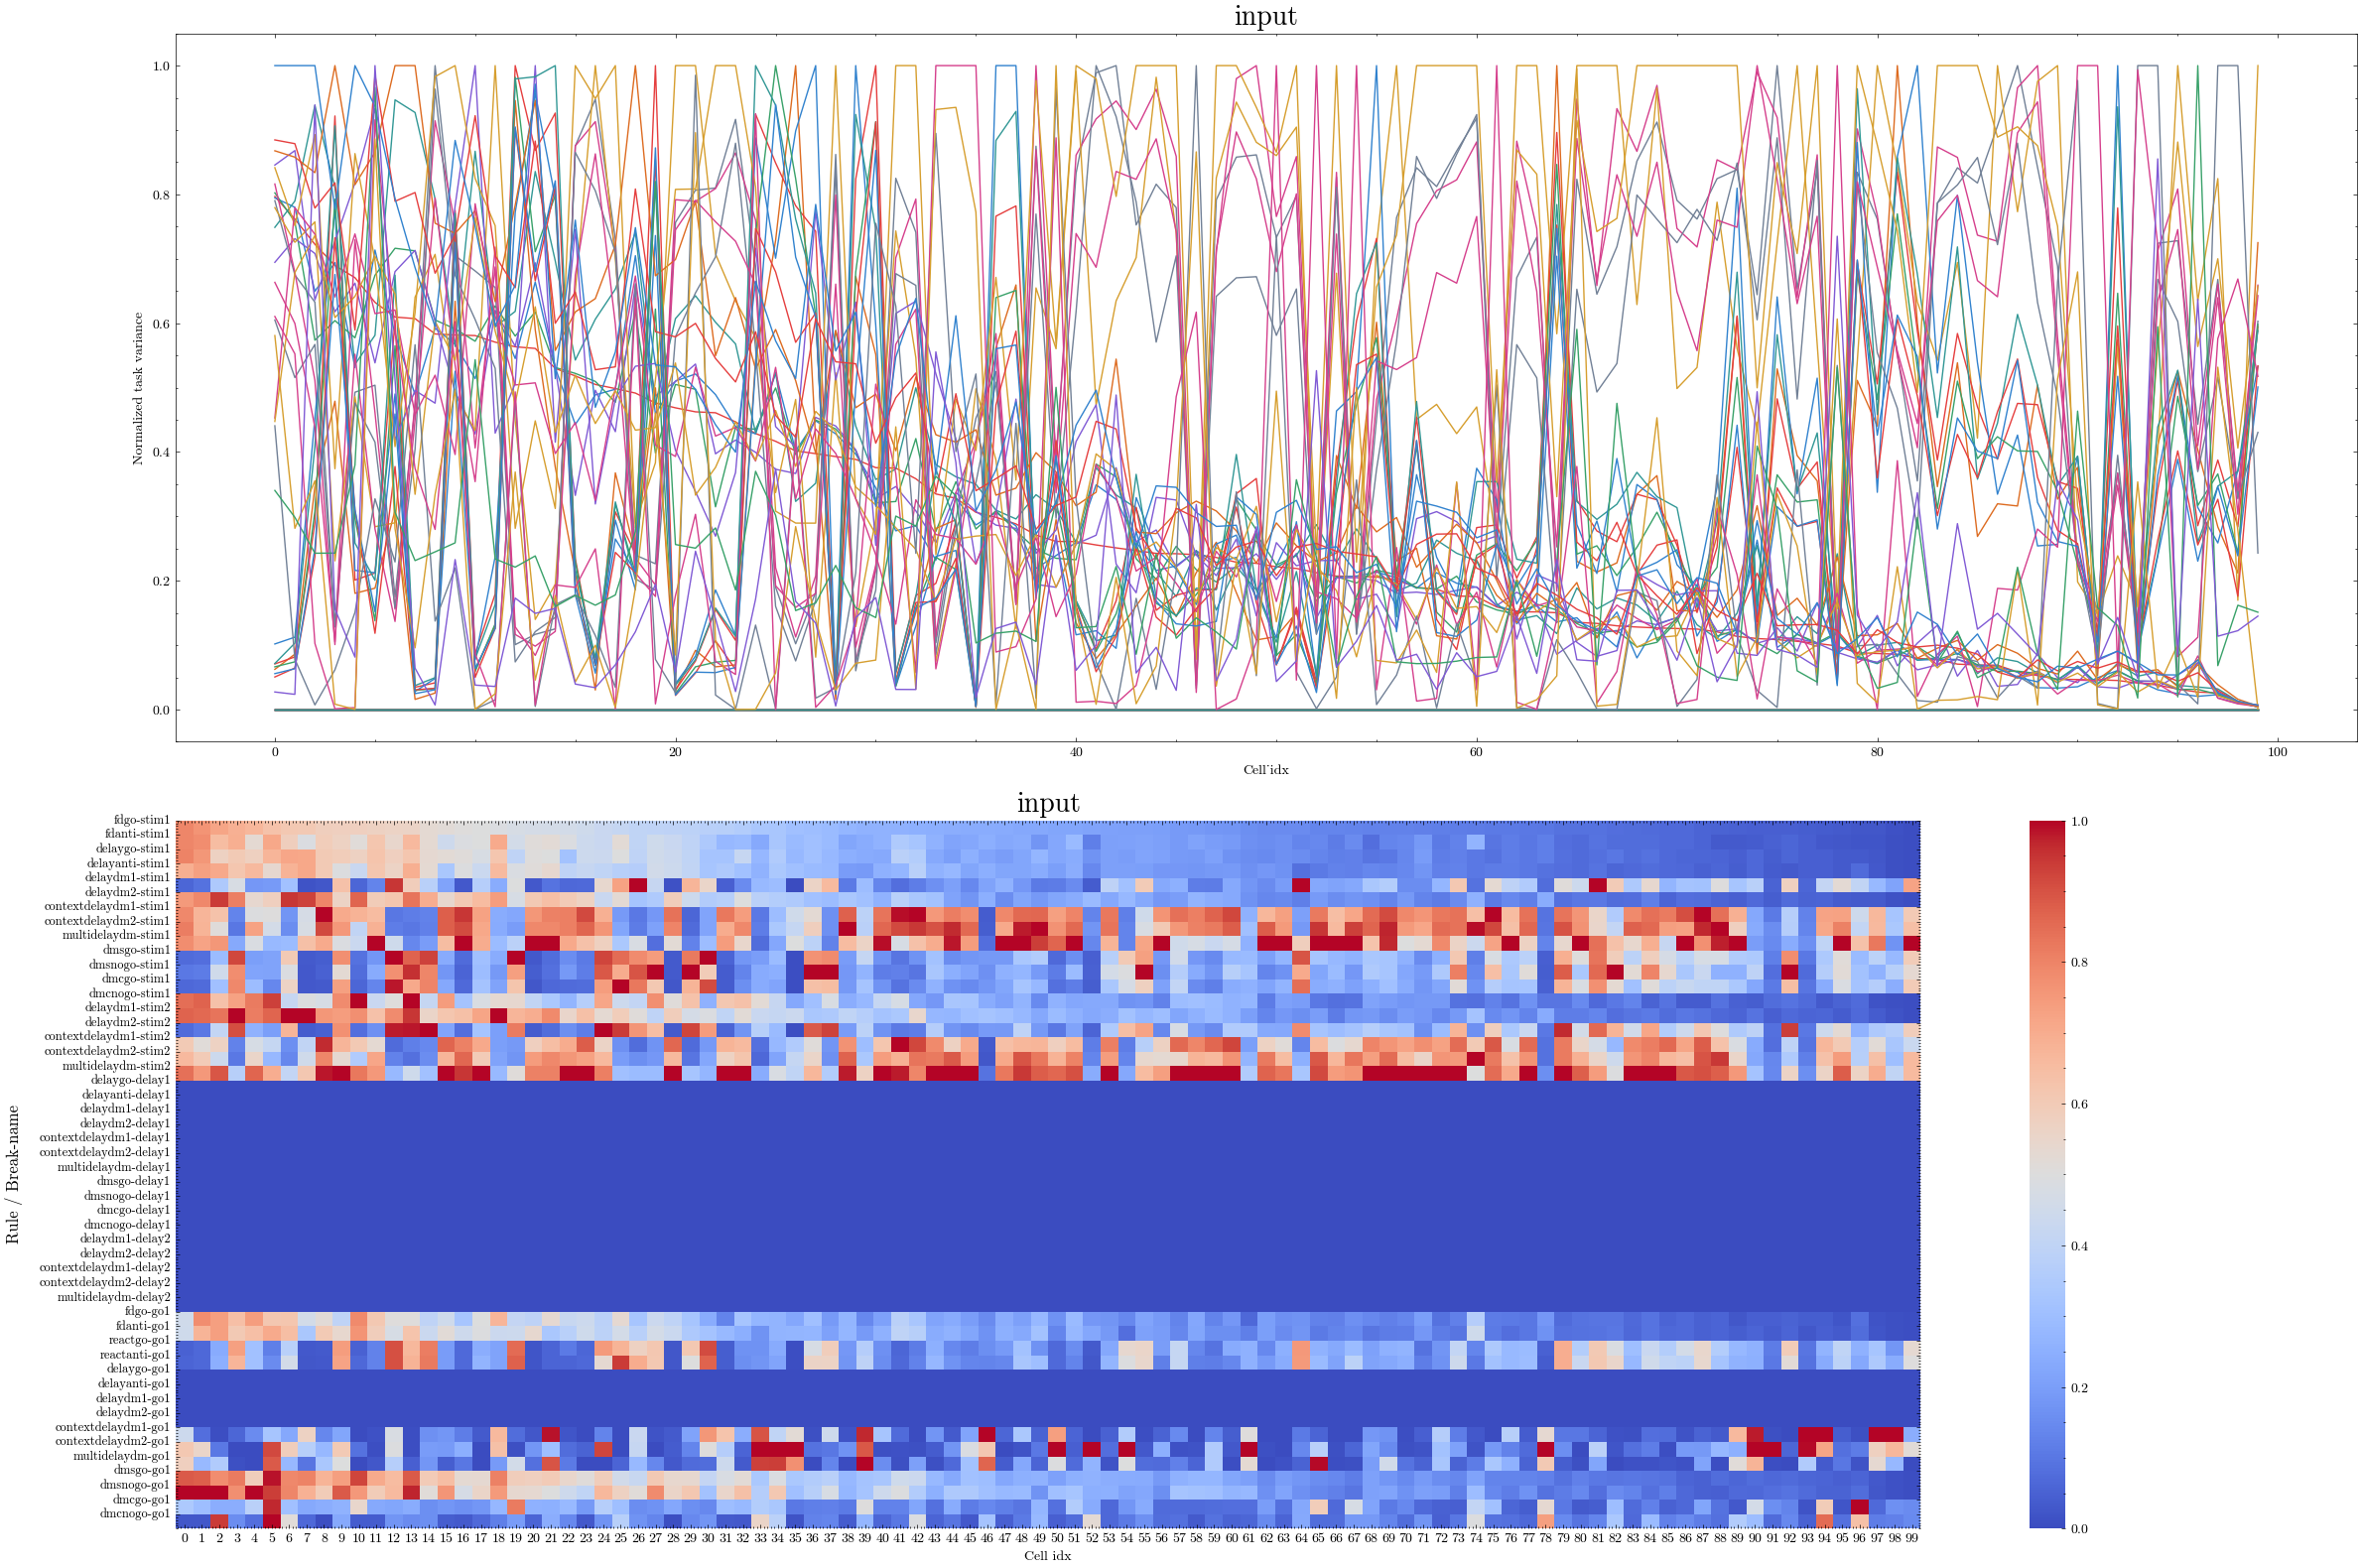

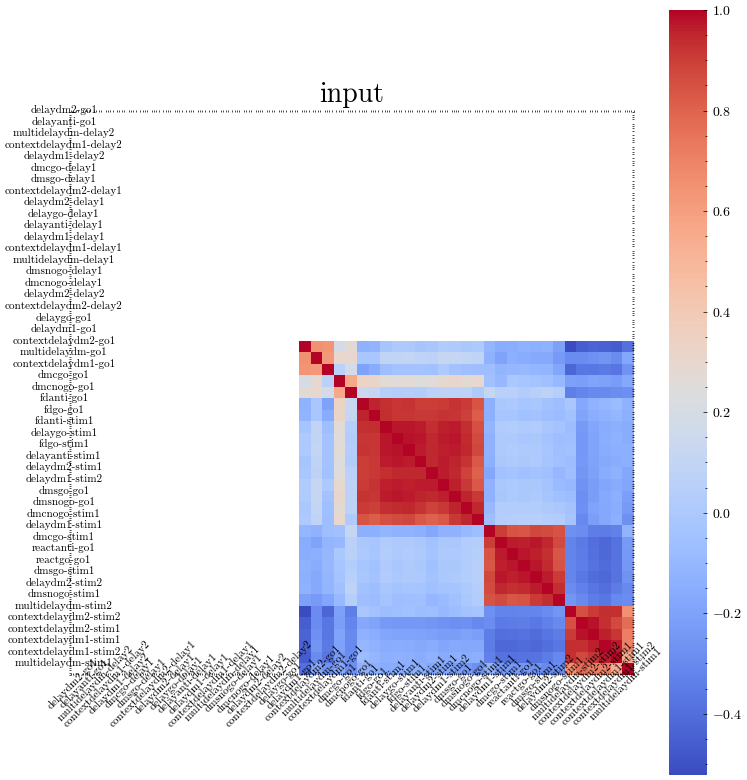

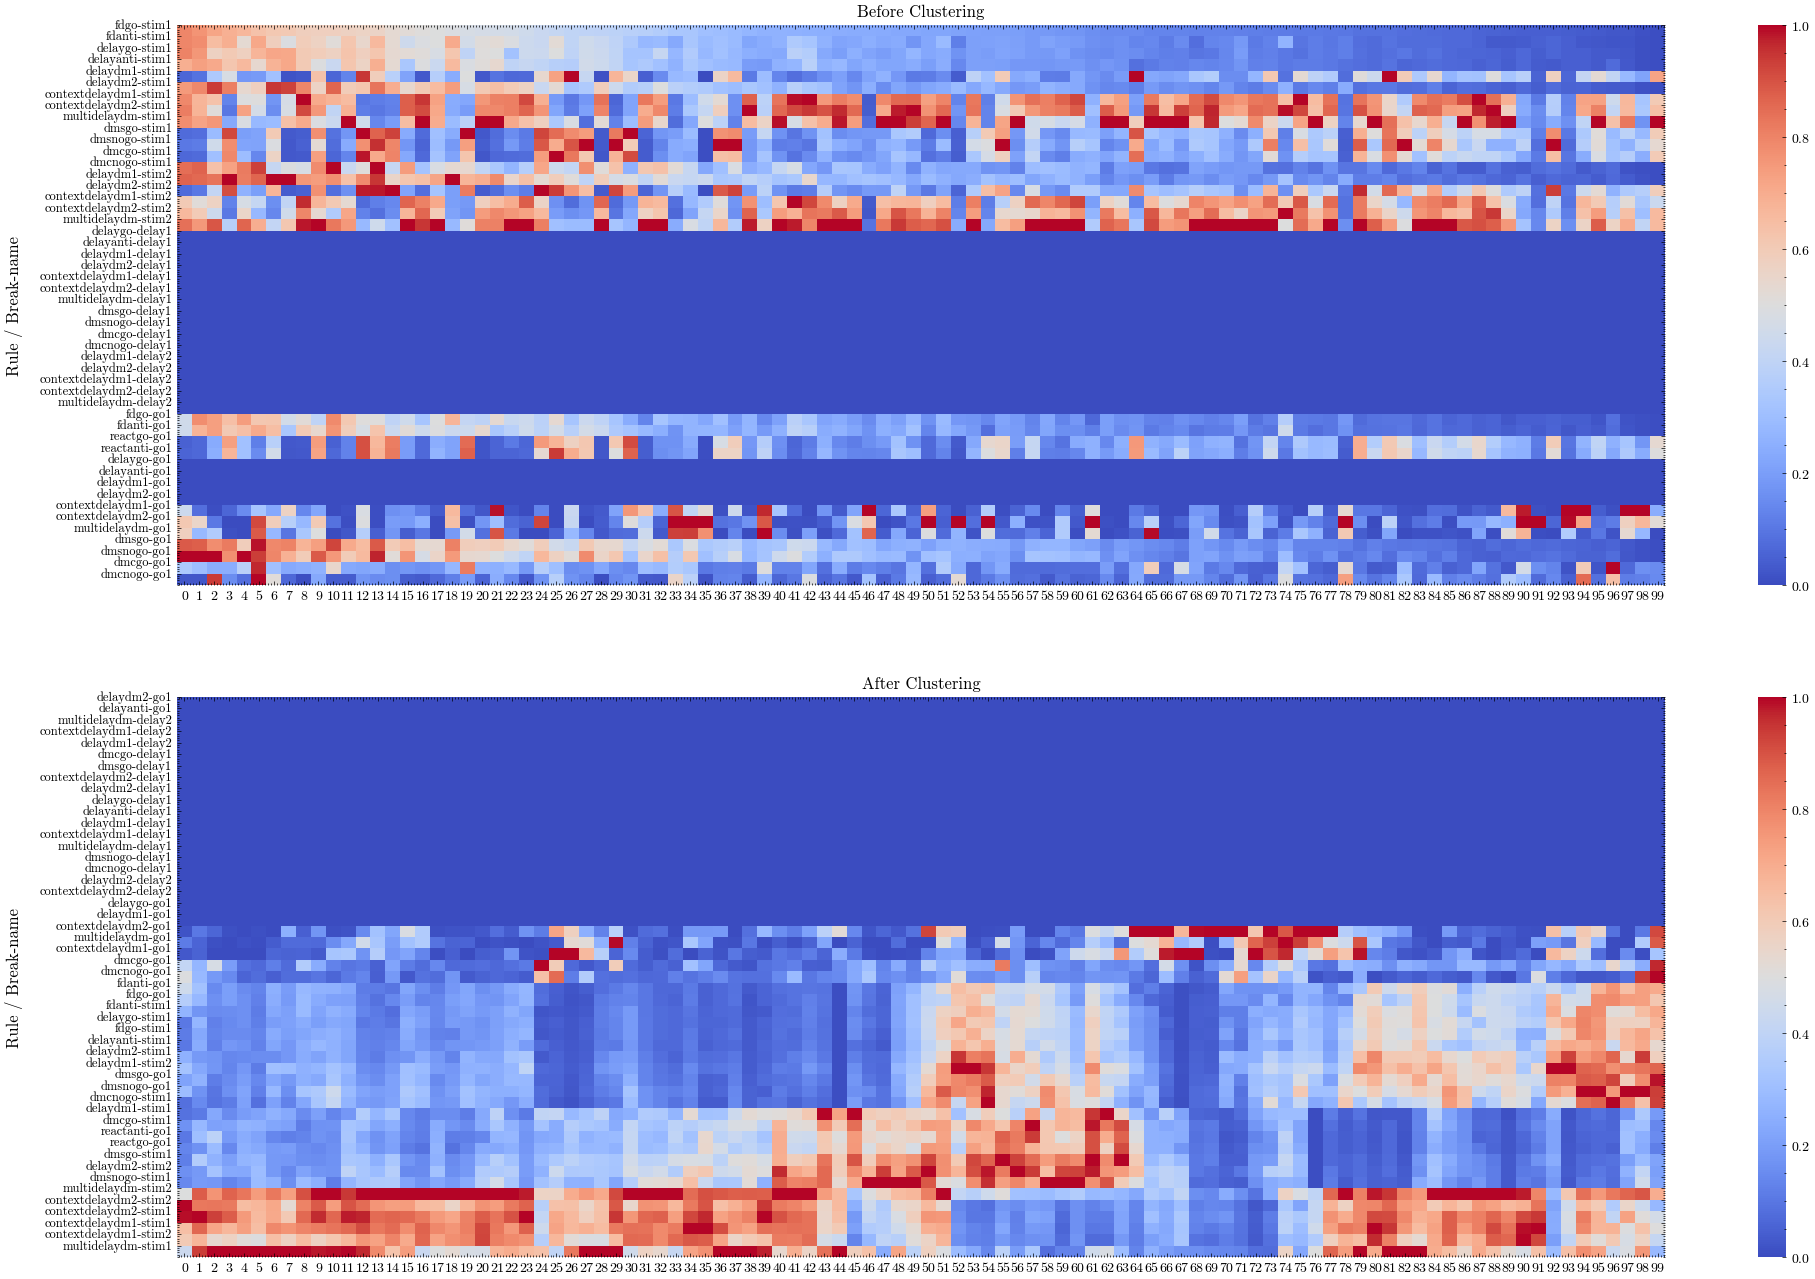

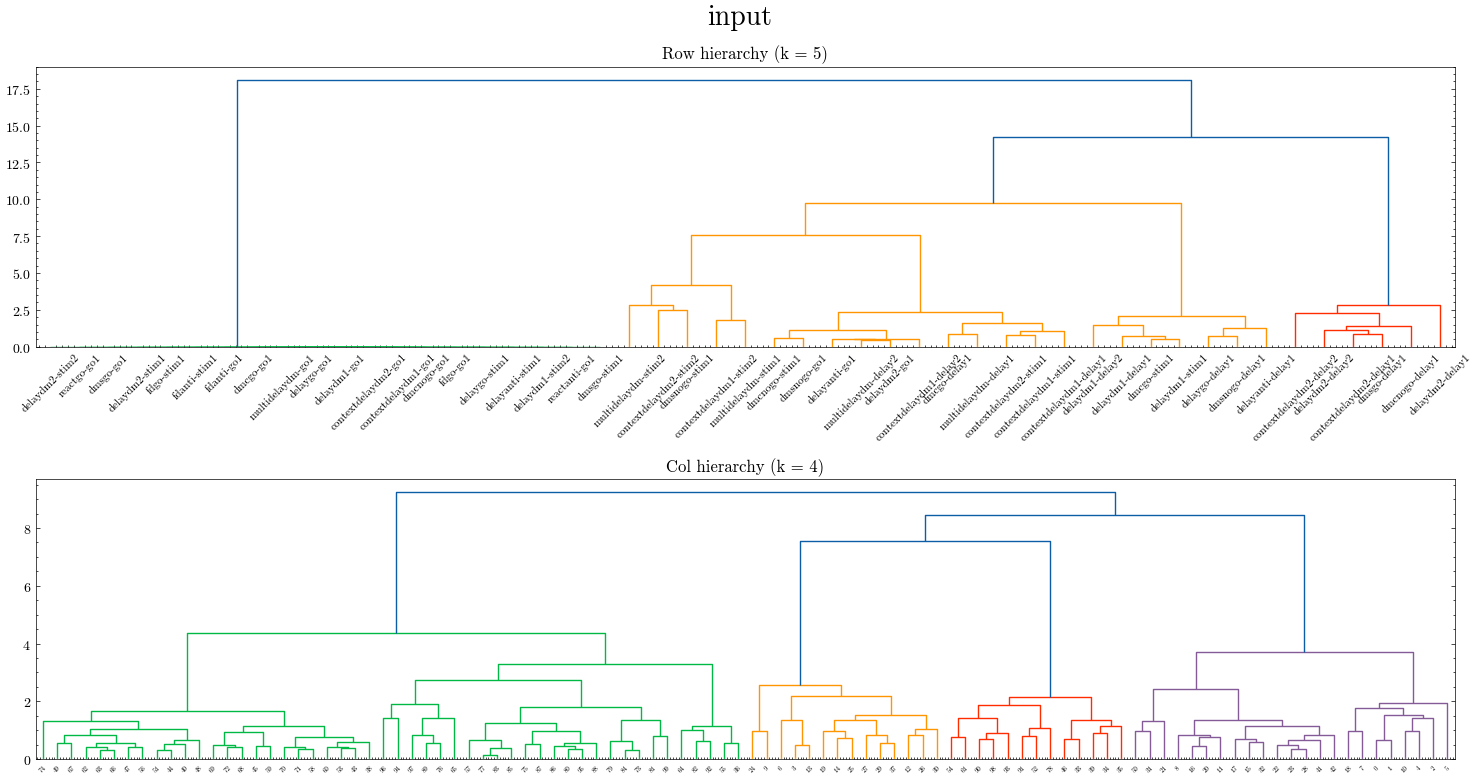

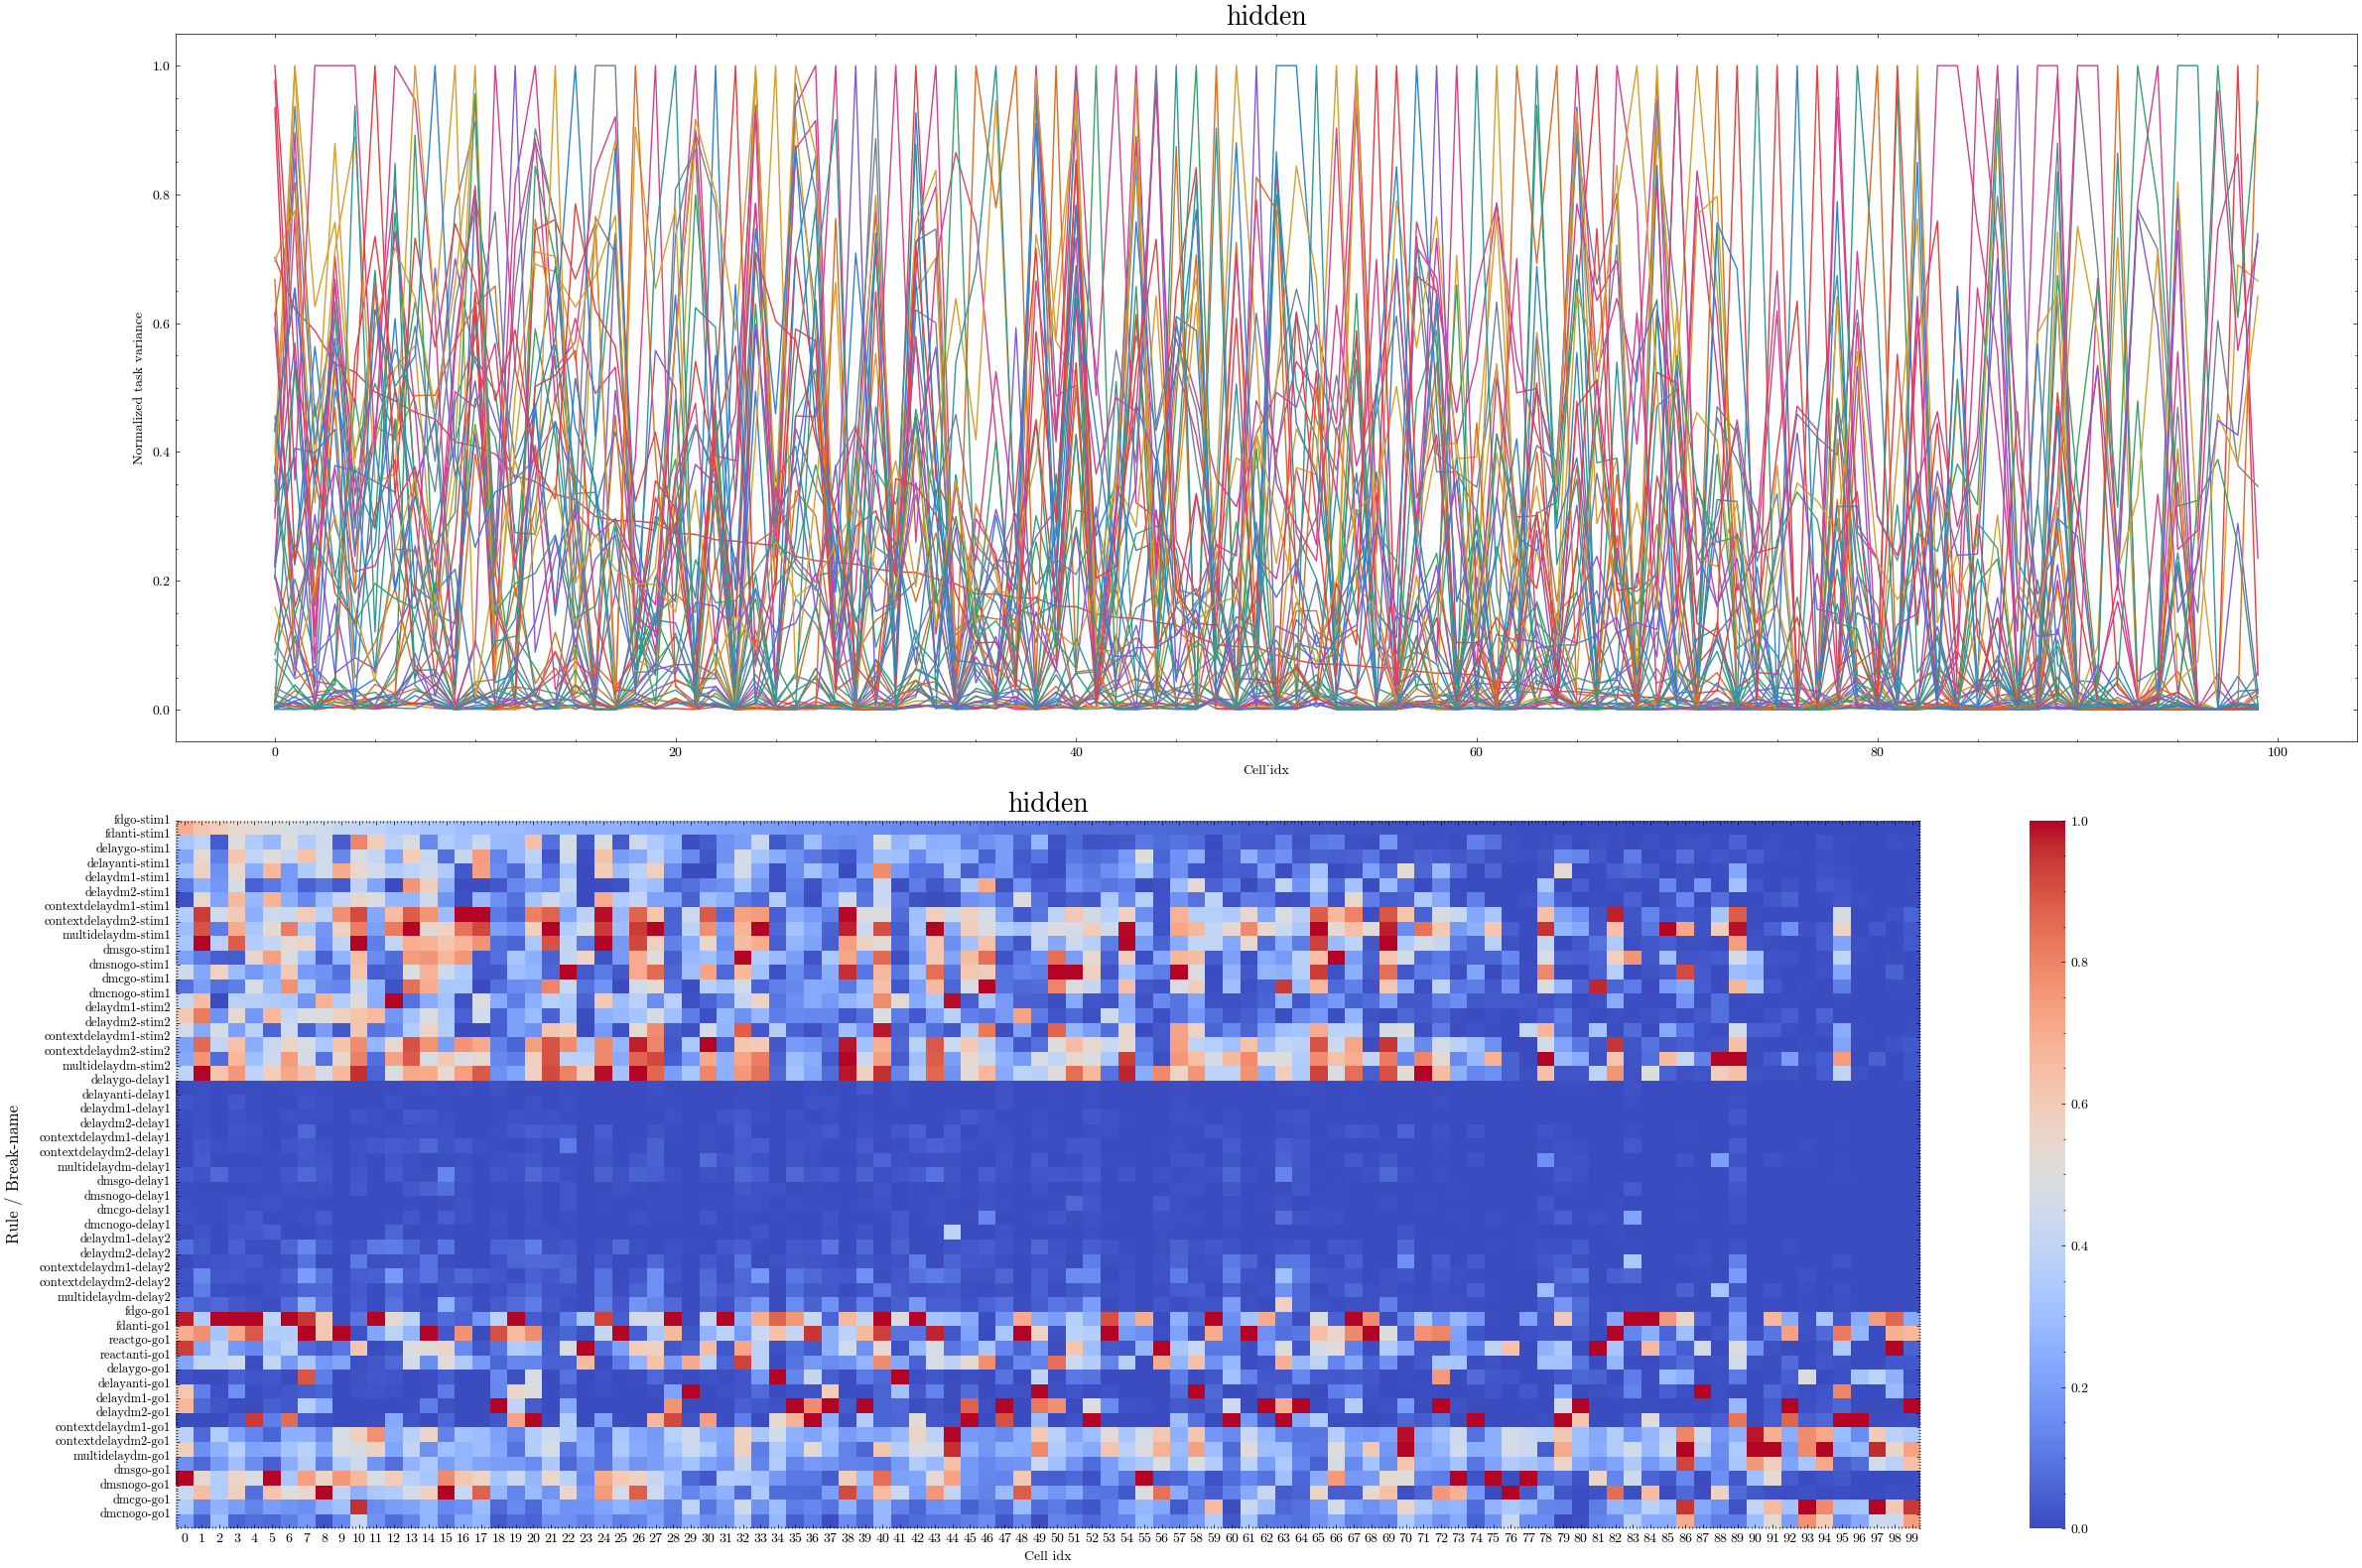

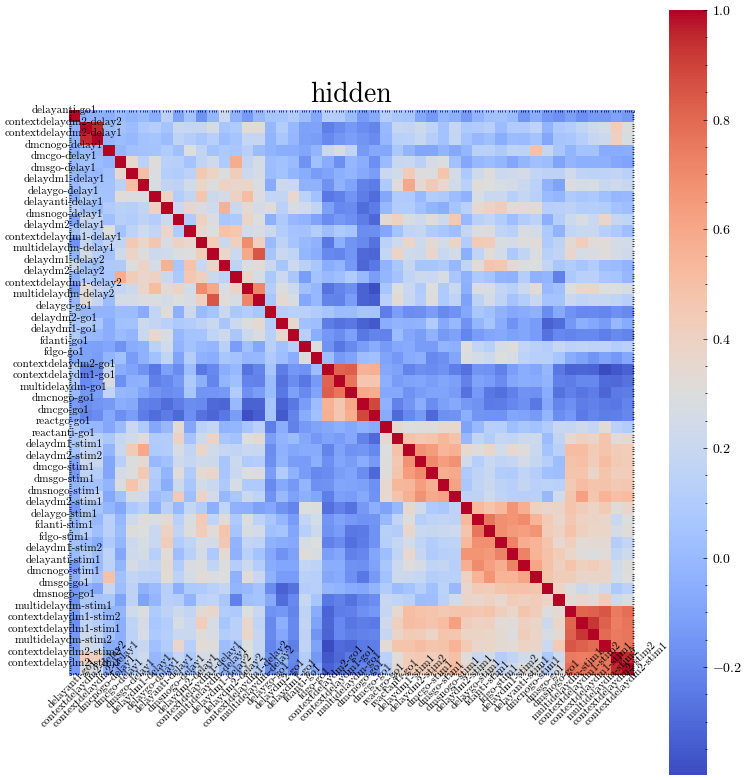

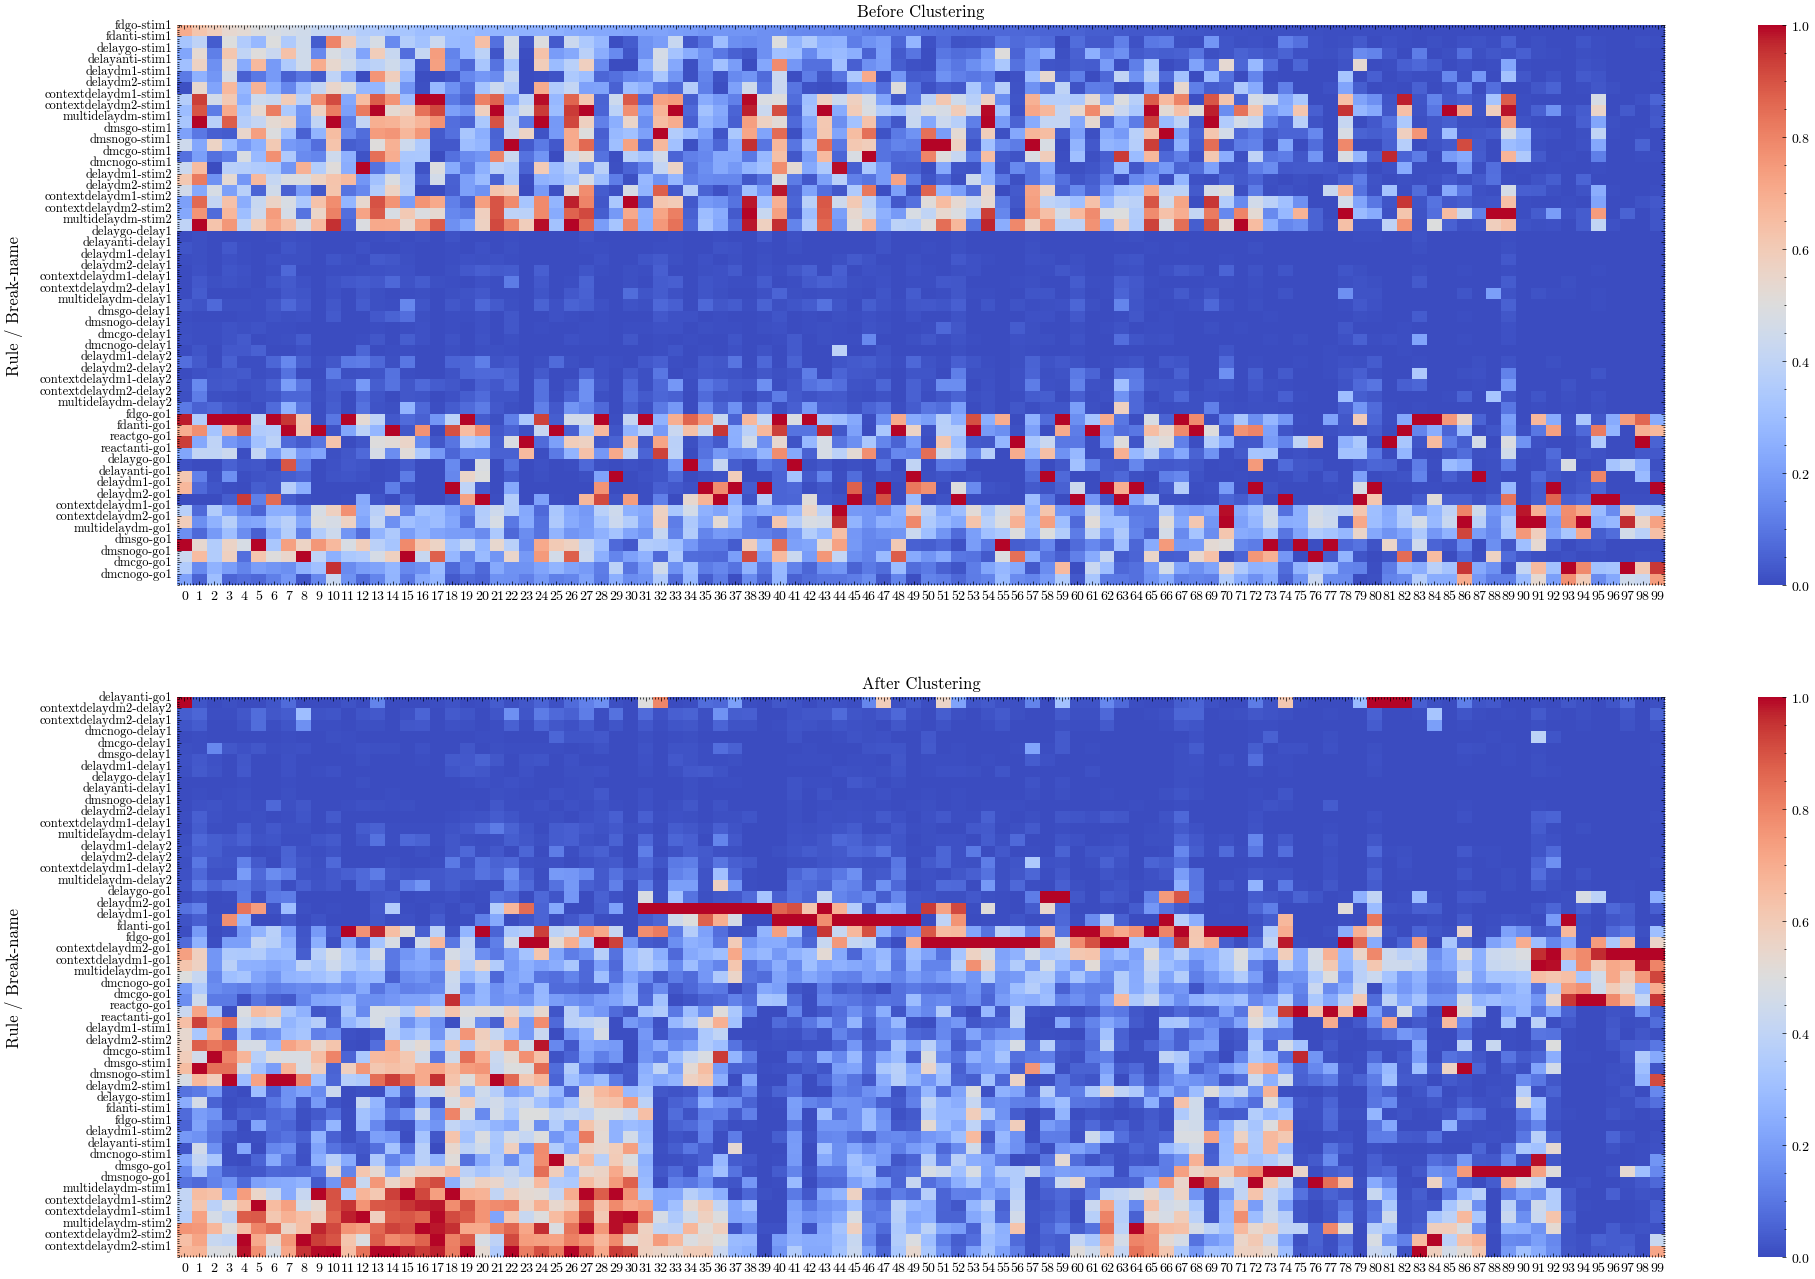

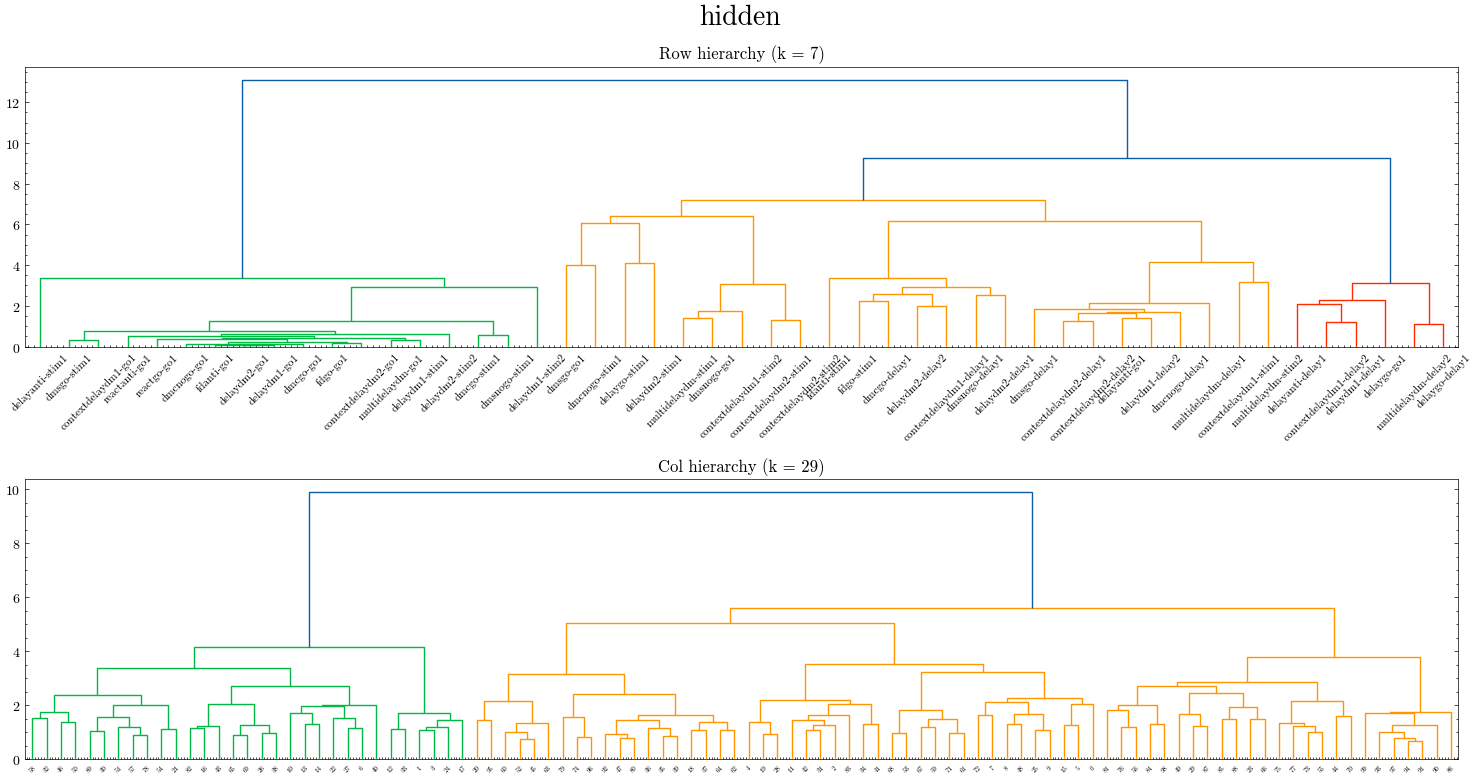

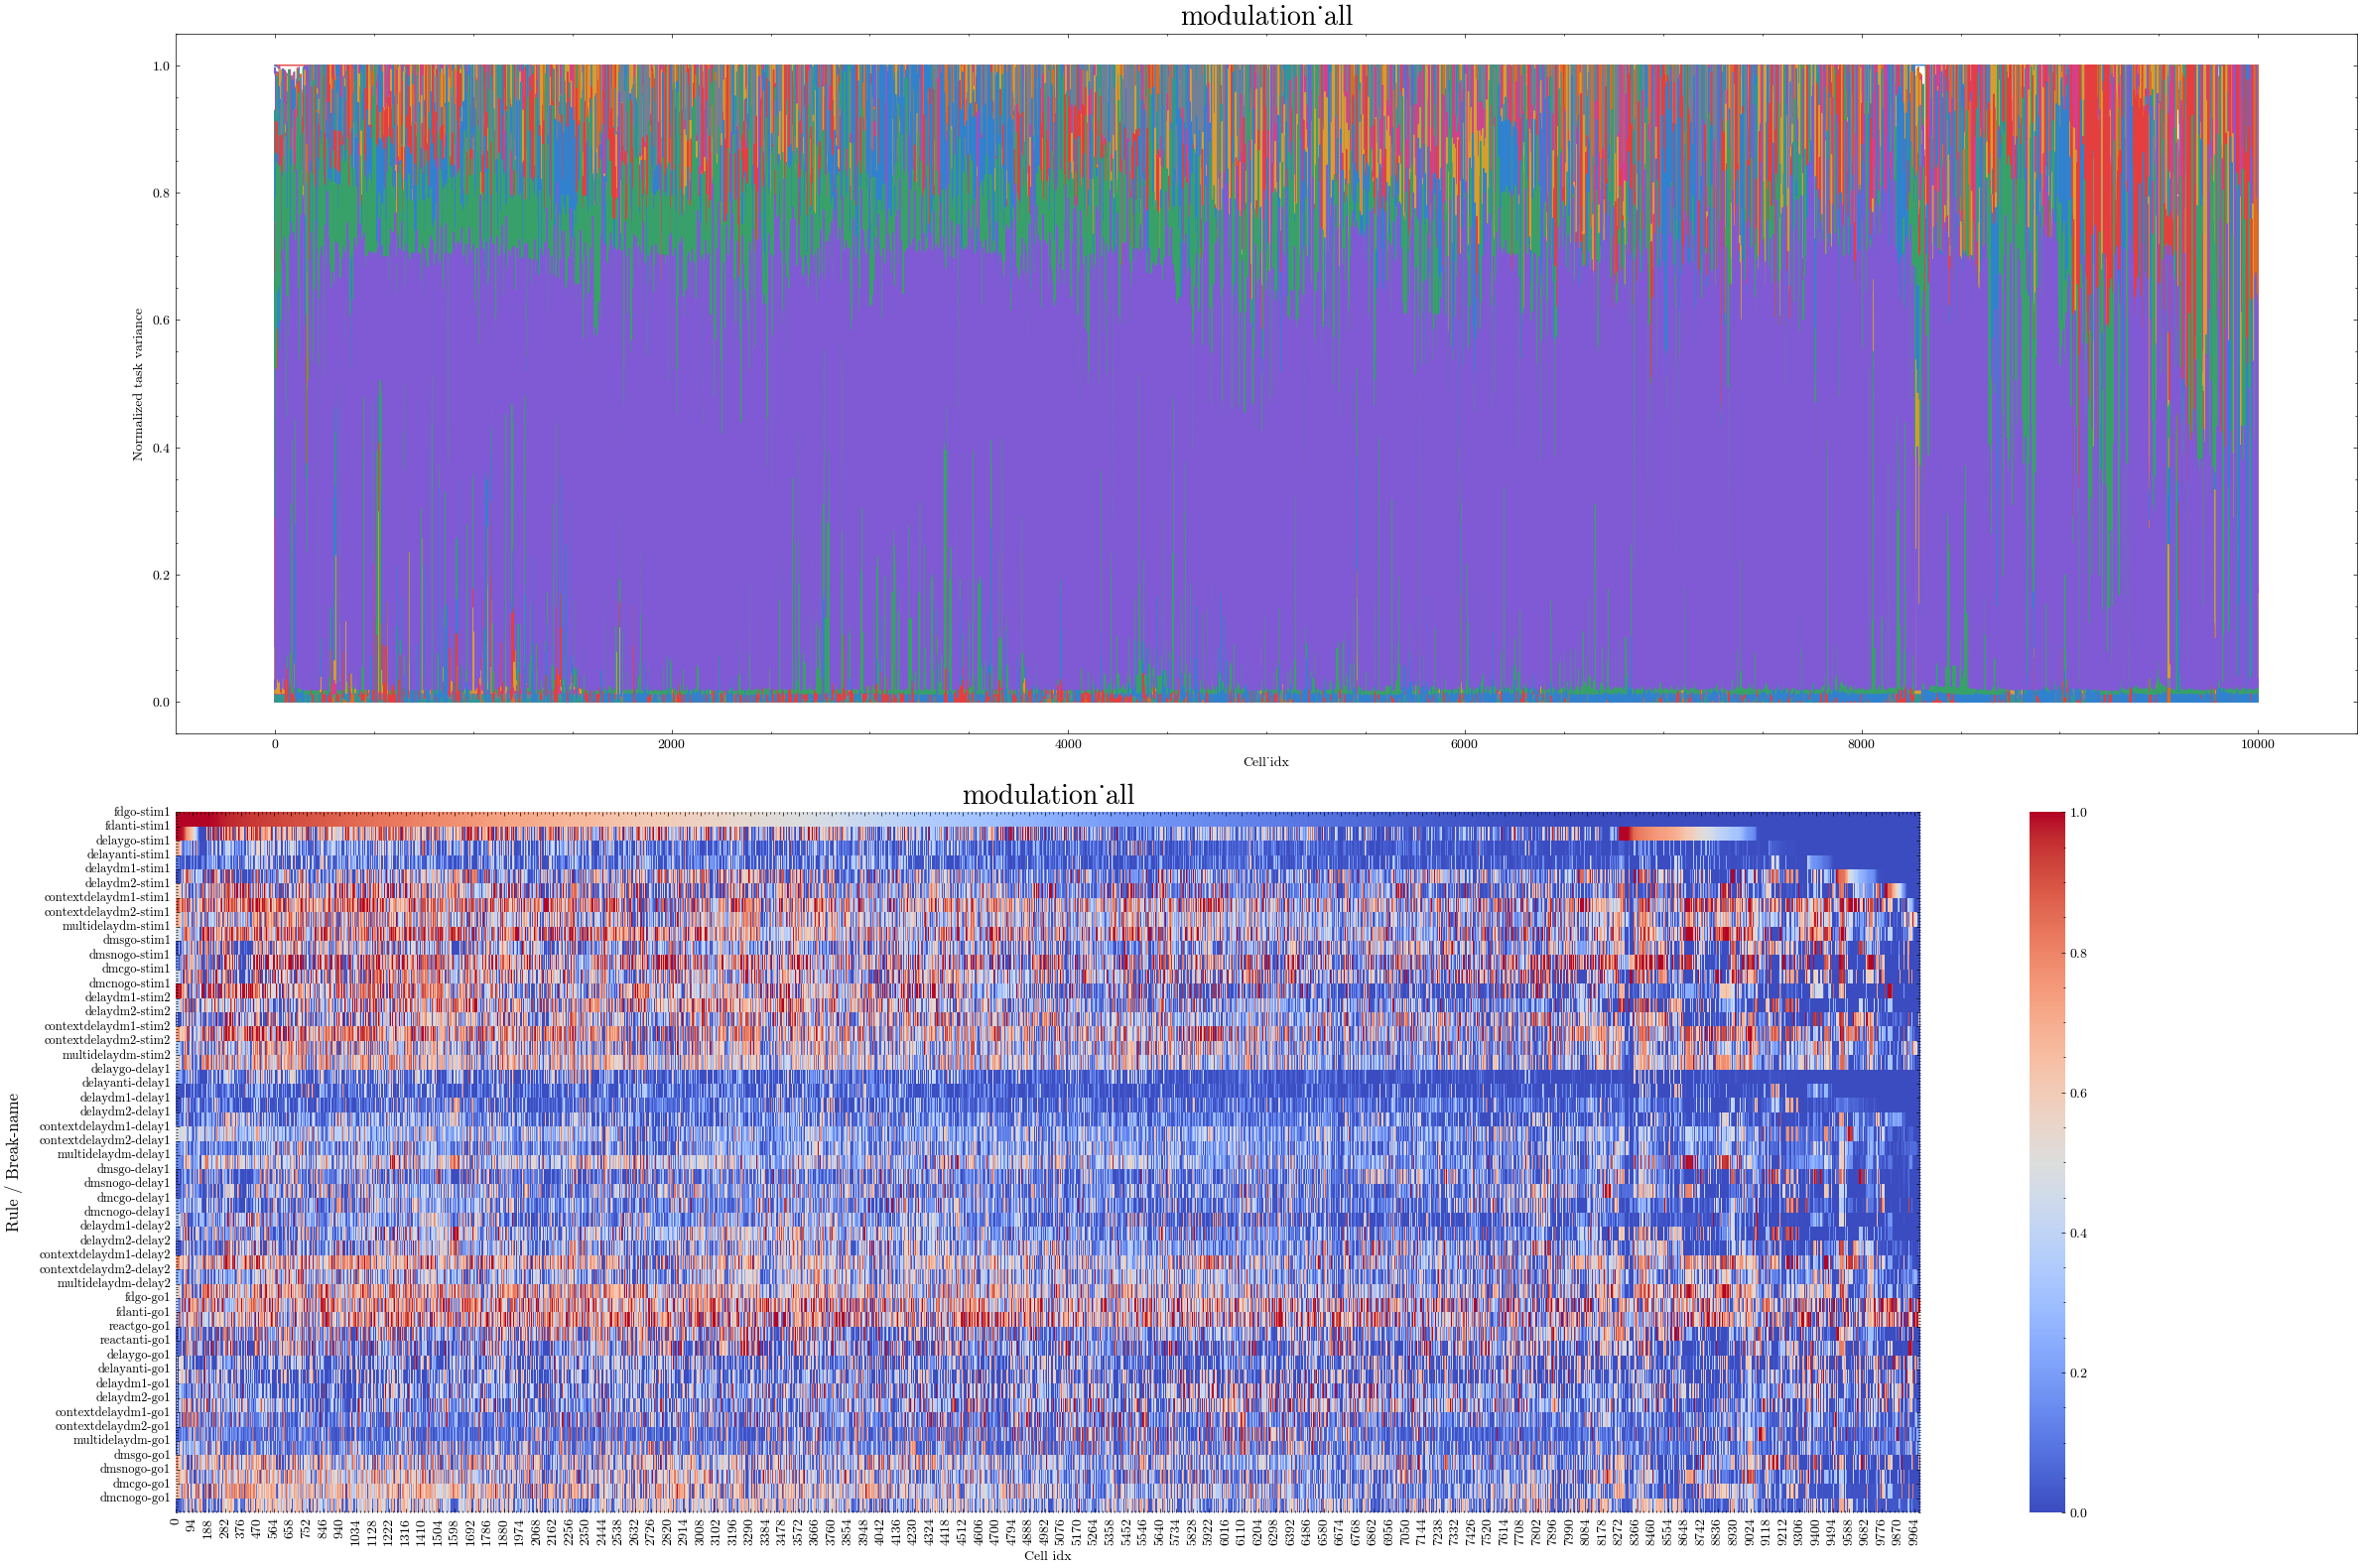

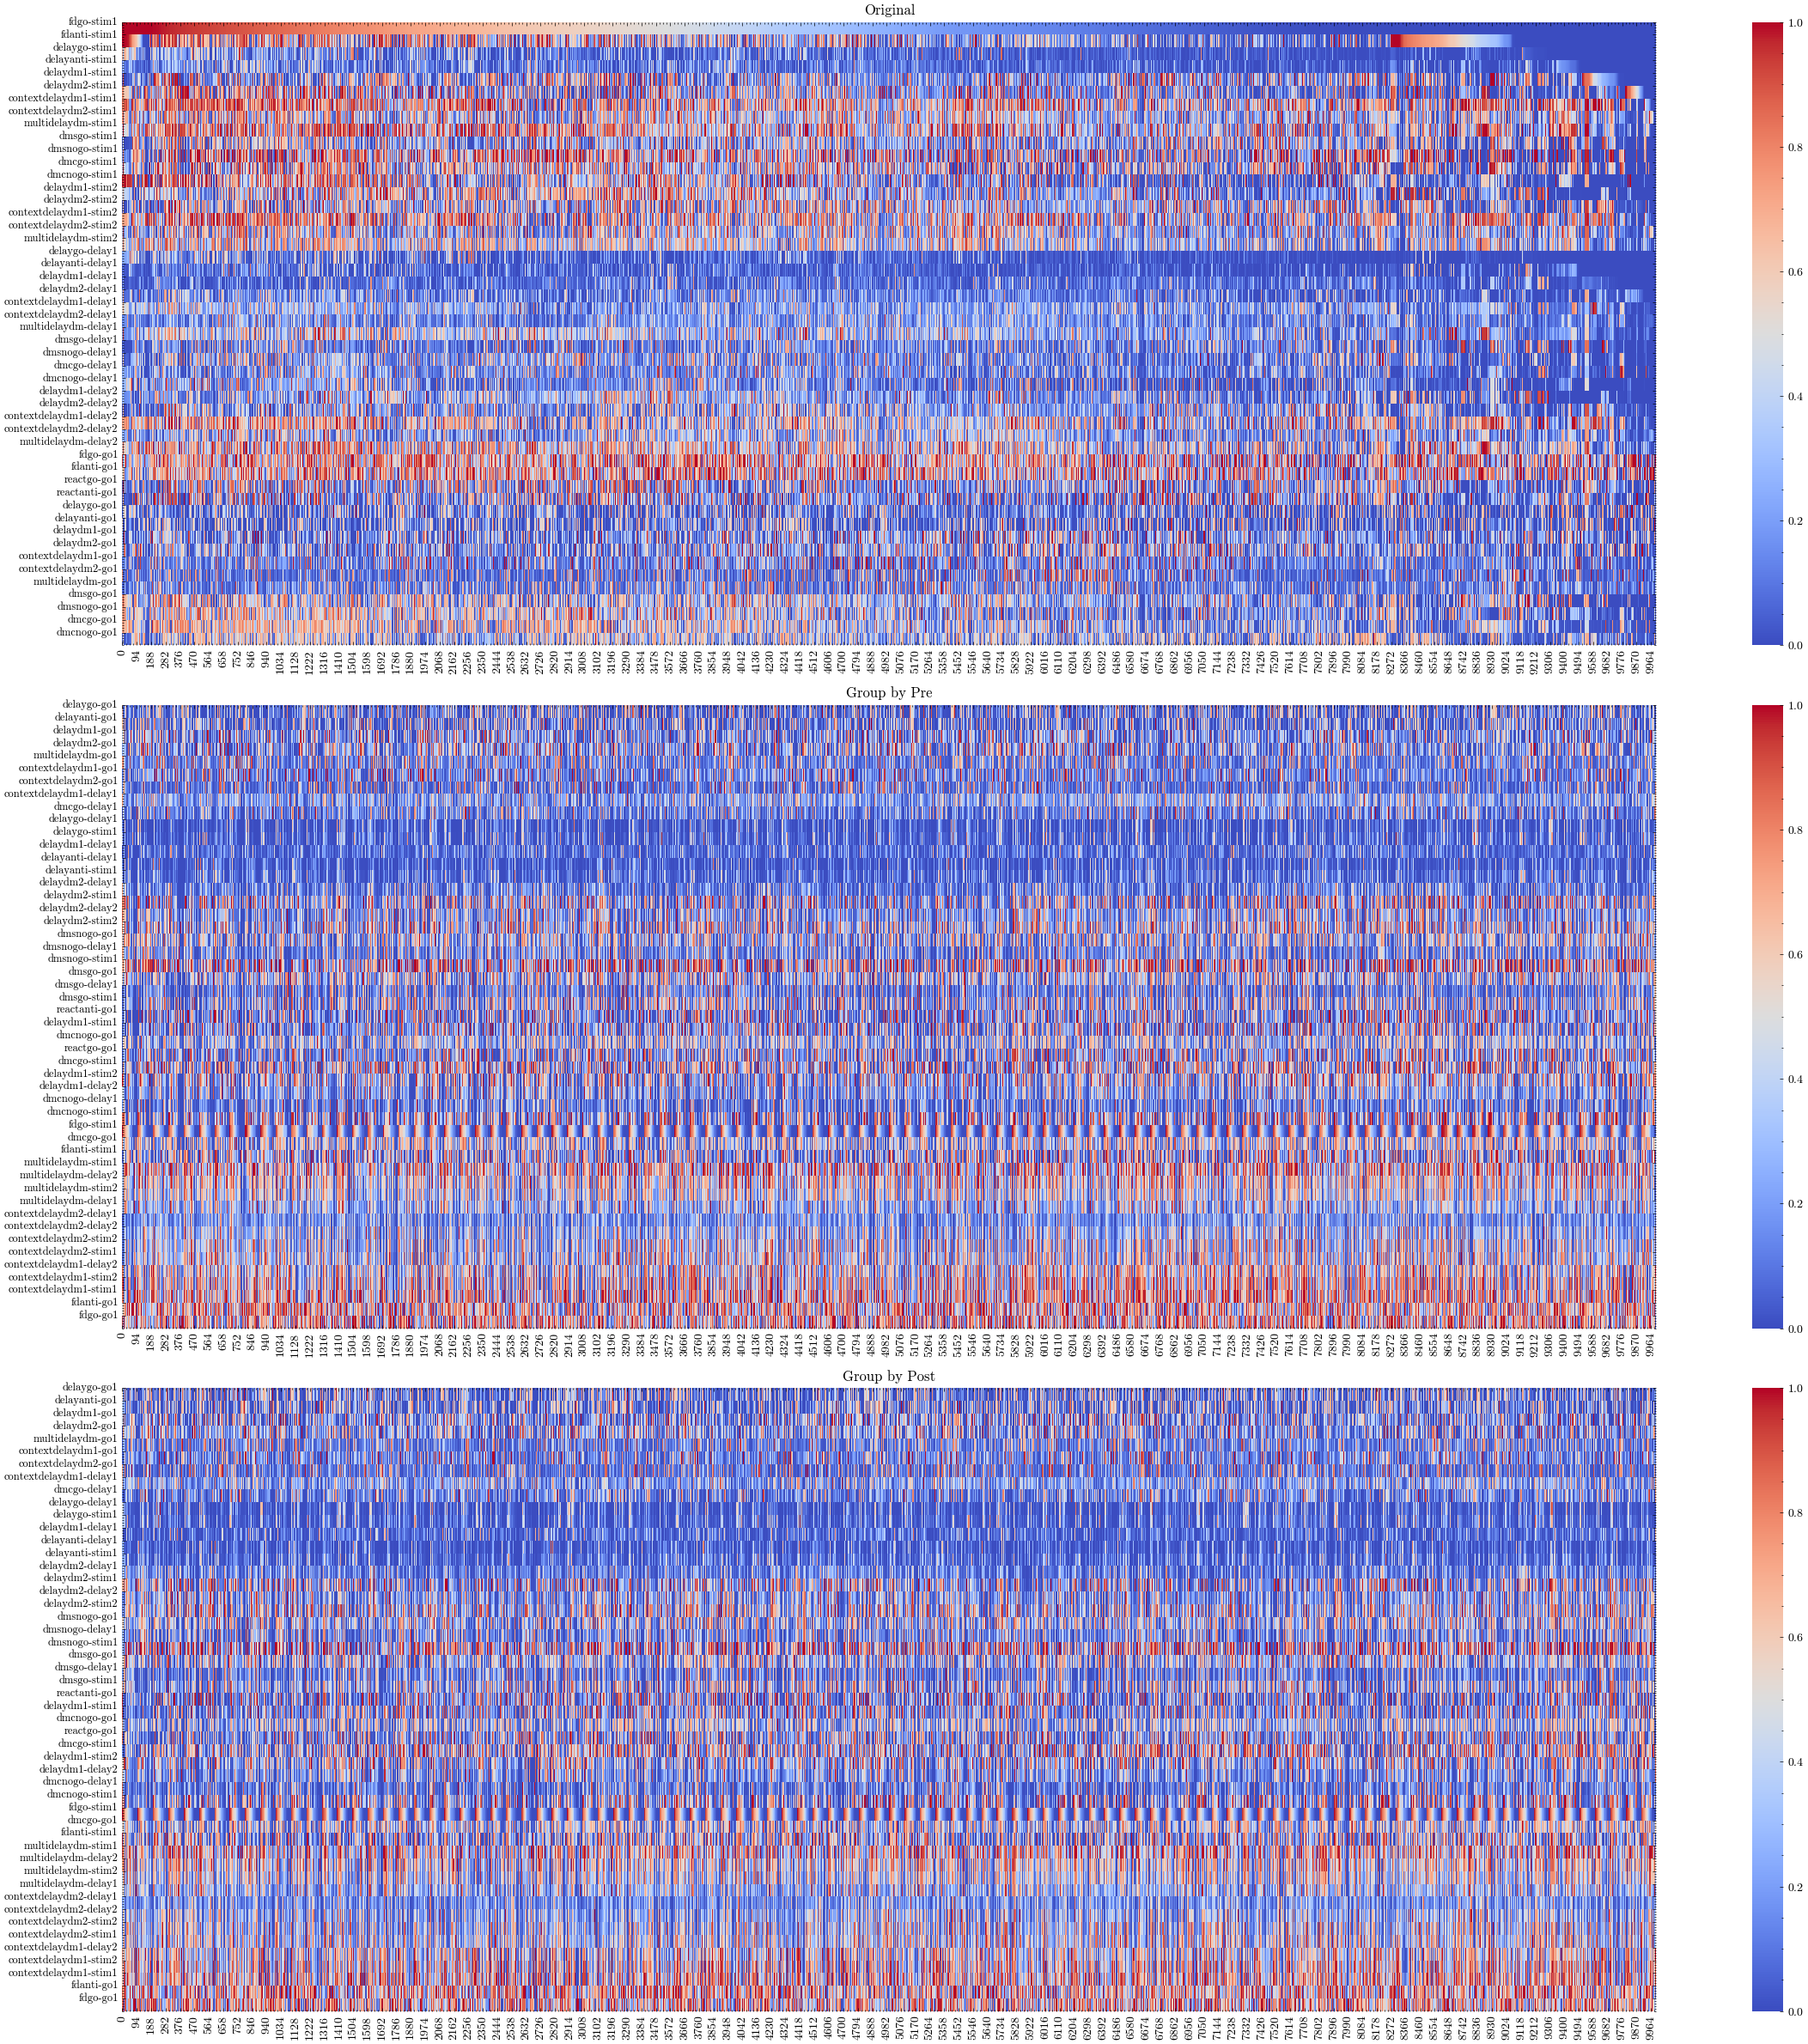

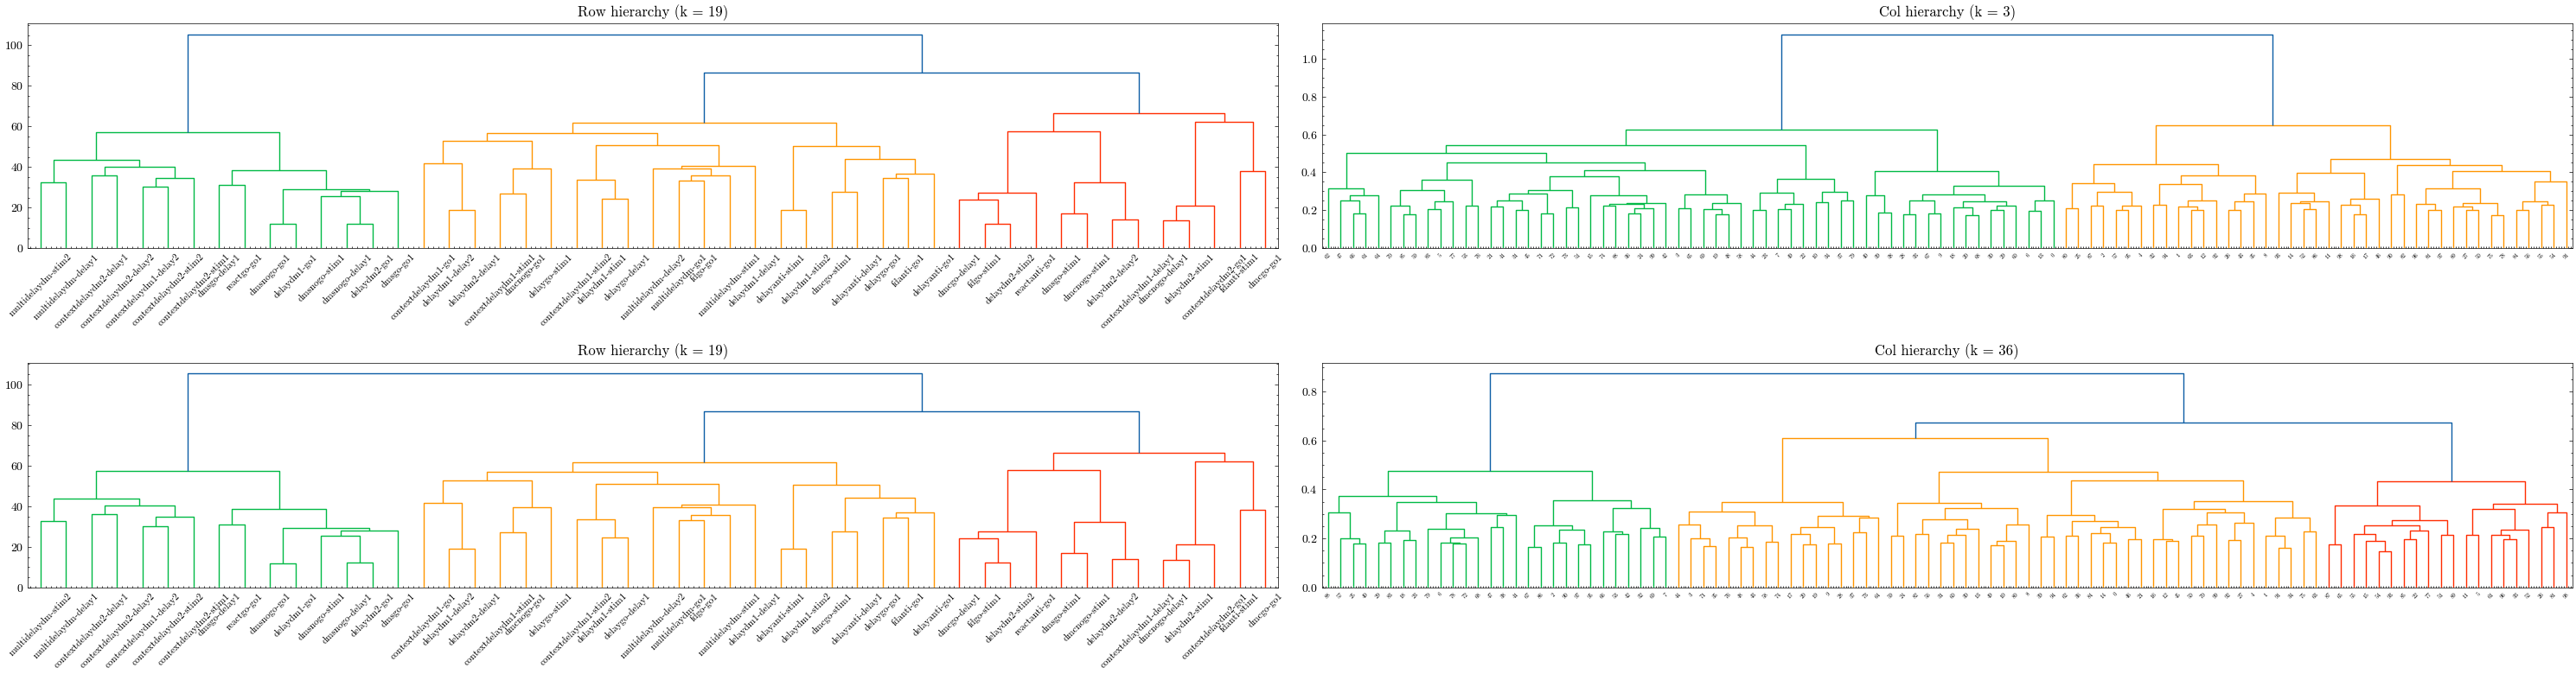

In [10]:
# start analysis 
clustering_data_analysis = [xs, hs, Ms_orig]
clustering_data_analysis_names = ["input", "hidden", "modulation_all"]
clustering_data_hierarchy = {}

for clustering_index in range(len(clustering_data_analysis)): 
    clustering_data = clustering_data_analysis[clustering_index]
    clustering_name = clustering_data_analysis_names[clustering_index]
    print(f"clustering_name: {clustering_name}")
    
    if hyp_dict['ruleset'] == "everything": 
        phase_to_indices = [
            ("stim1",  [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]),
            ("stim2",  [6, 7, 8, 9, 10]),
            ("delay1", [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]),
            ("delay2", [6, 7, 8, 9, 10]),
            ("go1",    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
        ]
    elif hyp_dict['ruleset'] == "contextdelaydm1":
        phase_to_indices = [
            ("stim1", [0]), 
            ("stim2", [0]), 
            ("delay1", [0]), 
            ("delay2", [0]), 
            ("go1", [0]), 
        ]

    elif hyp_dict['ruleset'] == "delaydm1":
        phase_to_indices = [
            ("stim1", [0]), 
            ("stim2", [0]), 
            ("delay1", [0]), 
            ("delay2", [0]), 
            ("go1", [0]), 
        ]

    elif hyp_dict['ruleset'] == "dmcgo":
        phase_to_indices = [
            ("stim1", [0]), 
            ("delay1", [0]), 
            ("go1", [0]), 
        ]
    
    tb_break = [
        [idx, rules_epochs[all_rules[idx]][phase]]
        for phase, indices in phase_to_indices
        for idx in indices
    ]
    
    tb_break_name = [
        f"{all_rules[idx]}-{phase}"
        for phase, indices in phase_to_indices
        for idx in indices
    ]
    
    tb_break_name = np.array(tb_break_name)
    
    cell_vars_rules = [] 
    
    for el in range(len(tb_break)):
        n_rules = len(task_params['rules'])
        n_cells = clustering_data.shape[-1]
            
        rule_idx, period_time = tb_break[el][0], tb_break[el][1]
        
        # print('Rule {} (idx {})'.format(all_rules[rule_idx], rule_idx))
        if len(clustering_data.shape) == 3:
            rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1], :]
            cell_vars_rules.append(np.var(rule_cluster, axis=(0, 1))) 
        else:
            clustering_data_old = clustering_data
            # calculate the mean value based on input
            if "pre" in clustering_name:
                rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1]]
                mean_var = np.var(rule_cluster, axis=(0, 1)).mean(axis=0)
                cell_vars_rules.append(mean_var)
                
            elif "post" in clustering_name: 
                rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1]]
                mean_var = np.var(rule_cluster, axis=(0, 1)).mean(axis=1)
                cell_vars_rules.append(mean_var)
                
            elif "all" in clustering_name: 
                clustering_data = clustering_data.reshape(clustering_data.shape[0], clustering_data.shape[1], -1)
                rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1], :]
                cell_vars_rules.append(np.var(rule_cluster, axis=(0, 1))) 
                    
    cell_vars_rules = np.array(cell_vars_rules)
    
    cell_vars_rules_norm = np.zeros_like(cell_vars_rules)
    
    # normalize
    cell_max_var = np.max(cell_vars_rules, axis=0) # Across rules
    for period_idx in range(len(tb_break)):
        cell_vars_rules_norm[period_idx] = np.where(
            cell_max_var > 0., cell_vars_rules[period_idx] / cell_max_var, 0.
        )
    
    # build rule-wise value lists and corresponding field names dynamically
    rule_vals  = [cell_vars_rules_norm[i].tolist() for i in range(n_rules)]
    # print(f"rule_vals: {rule_vals}")
    rule_names = [f"rule{i}" for i in range(n_rules)]
    
    # structured array whose fields are rule0, rule1, …, rule{n_rules-1}
    dtype = np.dtype([(name, float) for name in rule_names])
    rules_struct = np.array(list(zip(*rule_vals)), dtype=dtype)
    
    # descending lexicographic sort across all rule columns
    sort_idxs = np.argsort(rules_struct, order=rule_names)[::-1]

    # July 7th: first sorting based on the normalized magnitude
    # all the following should be aligned with this change

    def basic_sort(lst, sort_idxs):
        """Map each element in `lst` to its corresponding entry in `sort_idxs`."""
        return [sort_idxs[i] for i in lst]

    # sort it 
    cell_vars_rules_sorted_norm = cell_vars_rules_norm[:, sort_idxs]

    # plot 
    fig, ax = plt.subplots(2,1,figsize=(24,8*2))
    for period_idx in range(cell_vars_rules_sorted_norm.shape[0]): 
        ax[0].plot(cell_vars_rules_sorted_norm[period_idx], color=c_vals[period_idx],
                label=tb_break_name[period_idx])
    ax[0].set_xlabel('Cell_idx')
    ax[0].set_ylabel('Normalized task variance')
    ax[0].set_title(clustering_name, fontsize=20)
    
    sns.heatmap(cell_vars_rules_sorted_norm, ax=ax[1], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
    ax[1].set_xlabel('Cell idx')
    ax[1].set_ylabel('Rule / Break-name', fontsize=12, labelpad=12)
    ax[1].set_yticks(np.arange(len(tb_break_name)))
    ax[1].set_yticklabels(tb_break_name, rotation=0, ha='right', va='center', fontsize=9)
    ax[1].set_title(clustering_name, fontsize=20)
    fig.tight_layout()
    fig.savefig(f"./multiple_tasks/{clustering_name}_variance_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=100)   

    if not ("all" in clustering_name): 
        # clustering & grouping & re-ordering
        result = clustering.cluster_variance_matrix(cell_vars_rules_sorted_norm)
        cell_vars_rules_sorted_norm_ordered = cell_vars_rules_sorted_norm[np.ix_(result["row_order"], result["col_order"])]
    
        # pearson correlation matrix
        figcorr, axcorr = plt.subplots(1,1,figsize=(8,8))
        cell_vars_rules_sorted_norm_ordered_corr = np.corrcoef(cell_vars_rules_sorted_norm_ordered, rowvar=True)
        sns.heatmap(cell_vars_rules_sorted_norm_ordered_corr, cmap="coolwarm", square=True)
        axcorr.set_xticks(np.arange(len(tb_break_name)))
        axcorr.set_xticklabels(tb_break_name[result["row_order"]], rotation=45, ha='center', rotation_mode='anchor', fontsize=8)    
        axcorr.set_yticks(np.arange(len(tb_break_name)))
        axcorr.set_yticklabels(tb_break_name[result["row_order"]], rotation=0, ha='center', rotation_mode='anchor', fontsize=8) 
        axcorr.tick_params(axis="both", length=0)
        axcorr.set_title(clustering_name, fontsize=20)
        figcorr.tight_layout()
        figcorr.savefig(f"./multiple_tasks/{clustering_name}_variance_cluster_corr_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=100)

        # plot the effect of grouping & ordering through the feature axis
        fig, ax = plt.subplots(2,1,figsize=(24,8*2))
        sns.heatmap(cell_vars_rules_sorted_norm, ax=ax[0], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_ordered, ax=ax[1], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        ax[0].set_title("Before Clustering")
        ax[0].set_ylabel('Rule / Break-name', fontsize=12, labelpad=12)
        ax[0].set_yticks(np.arange(len(tb_break_name)))
        ax[0].set_yticklabels(tb_break_name, rotation=0, ha='right', va='center', fontsize=9)
        ax[1].set_title("After Clustering")
        ax[1].set_ylabel('Rule / Break-name', fontsize=12, labelpad=12)
        ax[1].set_yticks(np.arange(len(tb_break_name)))
        ax[1].set_yticklabels(tb_break_name[result["row_order"]], rotation=0, ha='right', va='center', fontsize=9)    
        fig.savefig(f"./multiple_tasks/{clustering_name}_variance_cluster_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=100)
        
        # plot hierarchy of grouping 
        fig, axs = plt.subplots(2,1,figsize=(15,4*2))
        dendrogram(result["row_linkage"], ax=axs[0], labels=tb_break_name[result["row_order"]], leaf_rotation=45)
        axs[0].set_title(f"Row hierarchy (k = {result['row_k']})")
        dendrogram(result["col_linkage"], ax=axs[1], labels=np.array([i for i in range(cell_vars_rules_sorted_norm_ordered.shape[1])]), leaf_rotation=45)
        axs[1].set_title(f"Col hierarchy (k = {result['col_k']})")
        fig.suptitle(clustering_name, fontsize=20)
        fig.tight_layout()
        fig.savefig(f"./multiple_tasks/{clustering_name}_variance_hierarchy_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        # register hierarchy clustering
        clustering_data_hierarchy[clustering_name] = result["col_linkage"]
        
    # plot the conditional grouping
    if ("all" in clustering_name): 
        assert len(clustering_data_old.shape) == 4
        pre_num, post_num = clustering_data_old.shape[2], clustering_data_old.shape[3]
        feature_group_post = [] 
        for i in range(post_num):
            feature_group_post.append(basic_sort([i + j * post_num for j in range(pre_num)], sort_idxs))
        feature_group_pre = []
        for i in range(pre_num):
            feature_group_pre.append(basic_sort([j for j in range(post_num * i, post_num * (i+1))], sort_idxs))

        # print(f"feature_group_pre: {feature_group_pre}")
        # print(f"feature_group_post: {feature_group_post}")
        print(f"cell_vars_rules_sorted_norm: {cell_vars_rules_sorted_norm.shape}")

        result_pre = clustering.cluster_variance_matrix_forgroup(cell_vars_rules_sorted_norm, row_groups=None, col_groups=feature_group_pre)
        cell_vars_rules_sorted_norm_pre = cell_vars_rules_sorted_norm[np.ix_(result_pre["row_order"], result_pre["col_order"])]
        result_post = clustering.cluster_variance_matrix_forgroup(cell_vars_rules_sorted_norm, row_groups=None, col_groups=feature_group_post)
        cell_vars_rules_sorted_norm_post = cell_vars_rules_sorted_norm[np.ix_(result_post["row_order"], result_post["col_order"])]

        clustering_data_hierarchy["modulation_all_pre"] = result_pre["col_linkage"]
        clustering_data_hierarchy["modulation_all_post"] = result_post["col_linkage"]
        print(result_post["col_linkage"].shape)

        figprepost, axprepost = plt.subplots(3,1,figsize=(24,8*3))
        sns.heatmap(cell_vars_rules_sorted_norm, ax=axprepost[0], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_pre, ax=axprepost[1], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_post, ax=axprepost[2], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        for ax in axprepost:
            ax.set_yticks(np.arange(len(tb_break_name)))
        axprepost[0].set_yticklabels(tb_break_name, rotation=0, ha='right', va='center', fontsize=9)
        axprepost[1].set_yticklabels(tb_break_name[result_pre["row_order"]], rotation=0, ha='right', va='center', fontsize=9)
        axprepost[2].set_yticklabels(tb_break_name[result_post["row_order"]], rotation=0, ha='right', va='center', fontsize=9)
        axprepost[0].set_title("Original")
        axprepost[1].set_title("Group by Pre")
        axprepost[2].set_title("Group by Post")
        figprepost.tight_layout()
        figprepost.savefig(f"./multiple_tasks/{clustering_name}_bygroup_variance_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=100)  

        fig, axs = plt.subplots(2,2,figsize=(15*2,4*2))
        dendrogram(result_pre["row_linkage"], ax=axs[0,0], labels=tb_break_name[result_pre["row_order"]], leaf_rotation=45)
        axs[0,0].set_title(f"Row hierarchy (k = {result_pre['row_k']})")
        dendrogram(result_pre["col_linkage"], ax=axs[0,1], labels=np.array([i for i in range(result_pre["col_linkage"].shape[0]+1)]), leaf_rotation=45)
        axs[0,1].set_title(f"Col hierarchy (k = {result_pre['col_k']})")
        dendrogram(result_post["row_linkage"], ax=axs[1,0], labels=tb_break_name[result_post["row_order"]], leaf_rotation=45)
        axs[1,0].set_title(f"Row hierarchy (k = {result_post['row_k']})")
        dendrogram(result_post["col_linkage"], ax=axs[1,1], labels=np.array([i for i in range(result_pre["col_linkage"].shape[0]+1)]), leaf_rotation=45)
        axs[1,1].set_title(f"Col hierarchy (k = {result_post['col_k']})")
        fig.tight_layout()
        fig.savefig(f"./multiple_tasks/{clustering_name}_bygroup_variance_hierarchy_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)  

coph1_pre = cophenet(clustering_data_hierarchy["input"])                
coph2_pre = cophenet(clustering_data_hierarchy["modulation_all_pre"])    
rho_pre, _ = spearmanr(coph1_pre, coph2_pre)
print(f"Pre: {rho_pre}")

coph1_post = cophenet(clustering_data_hierarchy["hidden"])                
coph2_post = cophenet(clustering_data_hierarchy["modulation_all_post"])    
rho_post, _ = spearmanr(coph1_post, coph2_post)
print(f"Post: {rho_post}")